In [116]:
import json
import numpy as np
import tensorflow as tf 
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
import nlpaug.augmenter.word as naw
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nlpaug.flow as naf
warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ekber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ekber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ekber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [117]:
vocab_size    = 10000
embedding_dim = 16
max_length    = 100
trunc_type    = 'post'
padding_type  = 'post'
oov_tok       = '<OOV>'
training_size = 20000

In [118]:
sentences = []
labels    = []

with open('Sarcasm_Headlines_Dataset_v2.json', 'r') as f:
    for line in f:
        item = json.loads(line)
        sentences.append(item['headline'])
        labels.append(item['is_sarcastic'])

In [119]:
stop_words = set(stopwords.words('english'))

cleaned_sentences = []
for sentence in sentences:

    sentence = sentence.lower()

    sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    word_tokens = word_tokenize(sentence)
    filtered_sentence = [word for word in word_tokens if word not in stop_words]

    cleaned_sentence = ' '.join(filtered_sentence)
    cleaned_sentences.append(cleaned_sentence)

In [145]:
cleaned_sentences_v2 = []
for sentence in cleaned_sentences:
    sentence = re.sub(r'\d+', '', sentence)
    cleaned_sentences_v2.append(sentence)

In [146]:
training_sentences = cleaned_sentences_v2[0:training_size]
testing_sentences  = cleaned_sentences_v2[training_size:]
training_labels    = labels[0:training_size]
testing_labels     = labels[training_size:]

In [147]:
# aug_synonym = naw.SynonymAug(aug_src='wordnet')

# aug_swap = naw.RandomWordAug(action='swap')

# aug_deletion = naw.RandomWordAug()


# aug_contextual = naw.ContextualWordEmbsAug(
#     model_path='distilbert-base-uncased', action='insert'
# )

# aug_pipeline = naf.Sequential([
#     aug_synonym,
#     # print("Executed aug_synonym"),
#     aug_swap,
#     # print("Executed aug_swap"),
#     aug_deletion,
#     # print("Executed aug_deletion"),
#     aug_contextual,
#     # print("Executed aug_contextual"),
# ])
# augmented_sentences = aug_pipeline.augment(training_sentences)
# print(training_sentences)
# print(augmented_sentences)

### WORD2VEC

In [148]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [149]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [150]:
print(training_padded.shape)
print(training_labels.shape)

(20000, 100)
(20000,)


In [151]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau # type: ignore

In [152]:
lstm_units=32
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(lstm_units, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,

)


In [153]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           160000    
                                                                 
 lstm_5 (LSTM)               (None, 100, 32)           6272      
                                                                 
 global_average_pooling1d_5  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 24)                792       
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                      

In [154]:
tf.keras.callbacks.CSVLogger(
    filename='Logger.csv', append=True, separator=','
)

csv_logger = CSVLogger("Logger.csv", append=True)

In [155]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=[early_stopping, csv_logger, reduce_lr])

Epoch 1/30
625/625 [==============================] - 20s 28ms/step - loss: 0.6923 - accuracy: 0.5214 - val_loss: 0.6912 - val_accuracy: 0.5249 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 17s 28ms/step - loss: 0.6695 - accuracy: 0.5738 - val_loss: 0.6380 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 17s 27ms/step - loss: 0.5616 - accuracy: 0.7141 - val_loss: 0.6439 - val_accuracy: 0.6821 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 17s 27ms/step - loss: 0.4708 - accuracy: 0.7986 - val_loss: 0.4829 - val_accuracy: 0.7890 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 18s 28ms/step - loss: 0.3982 - accuracy: 0.8354 - val_loss: 0.4519 - val_accuracy: 0.7786 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 16s 26ms/step - loss: 0.3524 - accuracy: 0.8482 - val_loss: 0.4908 - val_accuracy: 0.7957 - lr: 0.0010
Epoch 7/30
625/625 [==============================] - 17s 

In [156]:
with open('Logger.csv', 'a') as f:
    f.write('End Of The Trainning\n')

In [157]:
model.save('checkpoint_1.h5')

In [158]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [159]:
import matplotlib.pyplot as plt
import os

270/270 [==============================] - 3s 10ms/step


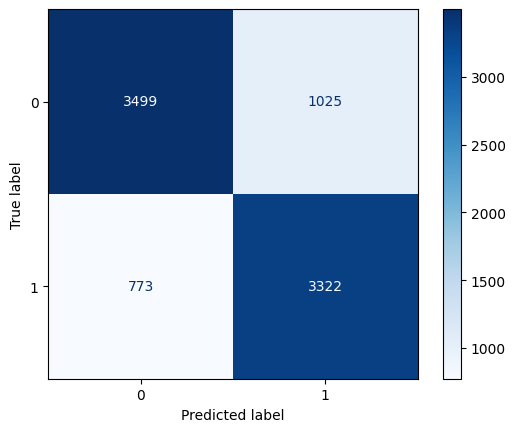

In [160]:
predictions = model.predict(testing_padded)
binary_predictions = [1 if x > 0.5 else 0 for x in predictions]
cm = confusion_matrix(testing_labels, binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

num_iter = 1 
f_name = f'file_{num_iter}.png'
while os.path.exists(f_name):
    num_iter += 1
    f_name = f'file_{num_iter}.png'
    
plt.savefig(f_name)
plt.show()

In [182]:
with open('non_sarcastic.txt', 'r') as non_sarcastic:
    non_sarcastic_sentences = non_sarcastic.readlines()

for non_sarcastic_sentence in non_sarcastic_sentences:
    token_list = tokenizer.texts_to_sequences([non_sarcastic_sentence])[0]
    token_list = pad_sequences([token_list], maxlen=max_length, padding='pre')

    prediction = model.predict(token_list)
    is_sarcastic = prediction[0][0] > 0.5

    if is_sarcastic:
        print(f"The text '{non_sarcastic_sentence.strip()}' is sarcastic.")
    else:
        print(f"The text '{non_sarcastic_sentence.strip()}' is not sarcastic.")

1/1 [==============================] - 0s 29ms/step
The text 'The weather is really nice today.' is not sarcastic.
1/1 [==============================] - 0s 33ms/step
The text 'I love spending time with my family.' is not sarcastic.
1/1 [==============================] - 0s 27ms/step
The text 'This chocolate cake is delicious.' is not sarcastic.
1/1 [==============================] - 0s 27ms/step
The text 'She is a very talented musician.' is not sarcastic.
1/1 [==============================] - 0s 26ms/step
The text 'The book I read was very interesting.' is not sarcastic.
1/1 [==============================] - 0s 33ms/step
The text 'I'm looking forward to the weekend.' is not sarcastic.
1/1 [==============================] - 0s 26ms/step
The text 'He is very knowledgeable about history.' is not sarcastic.
1/1 [==============================] - 0s 26ms/step
The text 'The movie was incredibly entertaining.' is not sarcastic.
1/1 [==============================] - 0s 44ms/step
The text 

In [183]:
with open('sarcastic.txt', 'r') as sarcastic:
    sarcastic_sentences = sarcastic.readlines()

for sarcastic_sentence in sarcastic_sentences:
    token_list = tokenizer.texts_to_sequences([sarcastic_sentence])[0]
    token_list = pad_sequences([token_list], maxlen=max_length, padding='pre')

    prediction = model.predict(token_list)
    is_sarcastic = prediction[0][0] > 0.5

    if is_sarcastic:
        print(f"The text '{sarcastic_sentence.strip()}' is sarcastic.")
    else:
        print(f"The text '{sarcastic_sentence.strip()}' is not sarcastic.")

1/1 [==============================] - 0s 33ms/step
The text 'Oh great, another Monday.' is not sarcastic.
1/1 [==============================] - 0s 43ms/step
The text 'I just love sitting in traffic.' is not sarcastic.
1/1 [==============================] - 0s 28ms/step
The text 'Yeah, like I really need more work.' is not sarcastic.
1/1 [==============================] - 0s 27ms/step
The text 'Sure, the weather is "fantastic" for a picnic.' is not sarcastic.
1/1 [==============================] - 0s 25ms/step
The text 'I can't wait to hear more of your advice.' is not sarcastic.
1/1 [==============================] - 0s 27ms/step
The text 'Oh, another meeting, how exciting!' is not sarcastic.
1/1 [==============================] - 0s 25ms/step
The text 'What a surprise, my train is late again.' is not sarcastic.
1/1 [==============================] - 0s 28ms/step
The text 'Just what I wanted, more rain.' is not sarcastic.
1/1 [==============================] - 0s 28ms/step
The text '